In [15]:
import pandas as pd
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('fivethirtyeight')


import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
import scipy.stats as stats


In [17]:
# NYC listings data sourced from http://insideairbnb.com/get-the-data.html
listings = pd.read_csv("data/listings/listings_2_19.csv")

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (43,61,62,94,95) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Data Cleaning

## Clean Zipcodes

In [18]:
def clean_zipcode(zipcode):
    '''
    Takes in zip code strings. If the first five characters are a zipcode, return zipcode, else return NaN.
    '''
    if zipcode[:5].isdigit():
        return zipcode[:5]
    else:
        return np.nan

In [19]:
#apply clean_zipcode function to zipcode column.
listings['zipcode'] = listings['zipcode'].astype(str).apply(lambda zipcode: clean_zipcode(zipcode))

## clean price

In [20]:
def priceString_to_float(df, column_name):
    '''
    take away dollar signs and commas and make a float
    '''
    df[column_name] = df[column_name].str.replace('$','')
    df[column_name] = df[column_name].str.replace(',', '').astype(float)

In [21]:
priceString_to_float(listings, 'price')

## check number of nan values for all columns

In [22]:
percent_not_nan = [(column, listings[column].count()/len(listings[column])) for column in listings]
sorted_by_percent = sorted(percent_not_nan, key=lambda item: item[1])
sorted_by_percent

[('thumbnail_url', 0.0),
 ('medium_url', 0.0),
 ('xl_picture_url', 0.0),
 ('host_acceptance_rate', 0.0),
 ('license', 0.00015927371187385522),
 ('jurisdiction_names', 0.00019909213984231904),
 ('square_feet', 0.008859600222983197),
 ('monthly_price', 0.11533407661065541),
 ('weekly_price', 0.1306840805924982),
 ('notes', 0.41102572270446763),
 ('host_response_rate', 0.5438201799792944),
 ('host_response_time', 0.5438400891932786),
 ('interaction', 0.5739627299514215),
 ('access', 0.577088476546946),
 ('house_rules', 0.6010790793979454),
 ('neighborhood_overview', 0.6181611849964164),
 ('host_about', 0.6182209126383691),
 ('security_deposit', 0.6331926415545114),
 ('transit', 0.6387074938281436),
 ('space', 0.7019192482280799),
 ('cleaning_fee', 0.7721987735924186),
 ('review_scores_location', 0.7734928725013936),
 ('review_scores_value', 0.7735127817153779),
 ('review_scores_checkin', 0.7735924185713148),
 ('review_scores_accuracy', 0.7740304212789679),
 ('review_scores_communication',

## eliminated columns with more than 30% null values

In [23]:

columns_with_nulls = ['thumbnail_url','medium_url','xl_picture_url', 'host_acceptance_rate','license','jurisdiction_names','square_feet','monthly_price',
 'weekly_price']
listings.drop(columns = columns_with_nulls, inplace = True)

## remove more columns based on content 

In [24]:
url_columns = ['listing_url', 'picture_url', "host_url", 'host_thumbnail_url',"host_picture_url"] 
text_columns = ['name', 'summary', 'space','description', 'neighborhood_overview','notes','transit','access','interaction','house_rules','host_about','host_name']
others_to_remove = ['experiences_offered','scrape_id','last_scraped','country','country_code','street','neighbourhood','state', 'city','latitude','longitude']

# experiences offered - all "none"
# scrape id - same for all of them
# last_scrapes - only 2 values - 43497, 43498
# market - new york for all of them 
# country code - US for all of them 
# country - United States for all of them
# neighborhood - don't need neighbourhood and neighborhood_cleansed
# street - same as city 
# state = NY for all of them
# city - same as neighbourhood group cleansed except "New York" instead of manhattan
# calendar last scraped - only 2 values: 43497, 43438



calculated = ['minimum_minimum_nights', 'maximum_minimum_nights','minimum_maximum_nights','maximum_maximum_nights','maximum_nights_avg_ntm', 'maximum_nights_avg_ntm','calculated_host_listings_count', 'calculated_host_listings_count_entire_homes','calculated_host_listings_count_private_rooms','calculated_host_listings_count_shared_rooms']

# removed some columns that were engineered features that the site where we got the data from made

#listings.drop(columns = url_columns + text_columns + others_to_remove + calculated, inplace = True)



In [25]:
listings.drop(columns = url_columns + text_columns + others_to_remove + calculated, inplace = True)

## distribution of price

count    50228.000000
mean       150.484889
std        225.907959
min          0.000000
25%         69.000000
50%        108.000000
75%        175.000000
max      10000.000000
Name: price, dtype: float64


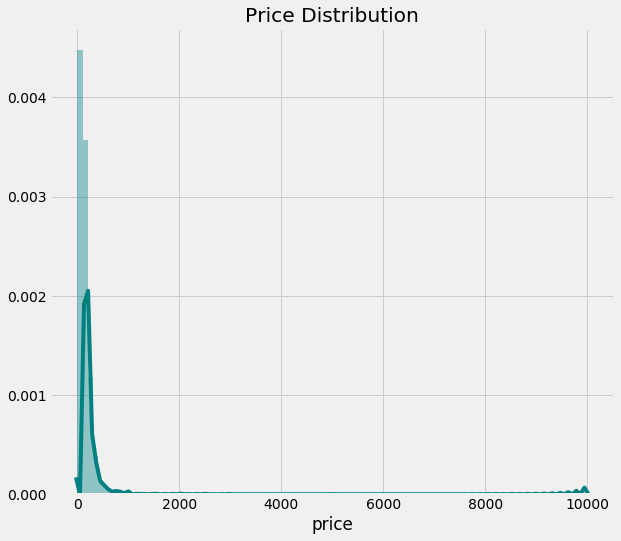

In [27]:
print(listings['price'].describe())
plt.figure(figsize=(9, 8))
sns.distplot(listings['price'], color='teal', bins=100).set_title('Price Distribution');

## continuous variables (stored as ints and floats)

In [1153]:
list(set(listings.dtypes.tolist()))

[dtype('int64'), dtype('O'), dtype('float64')]

## Distribution Plots

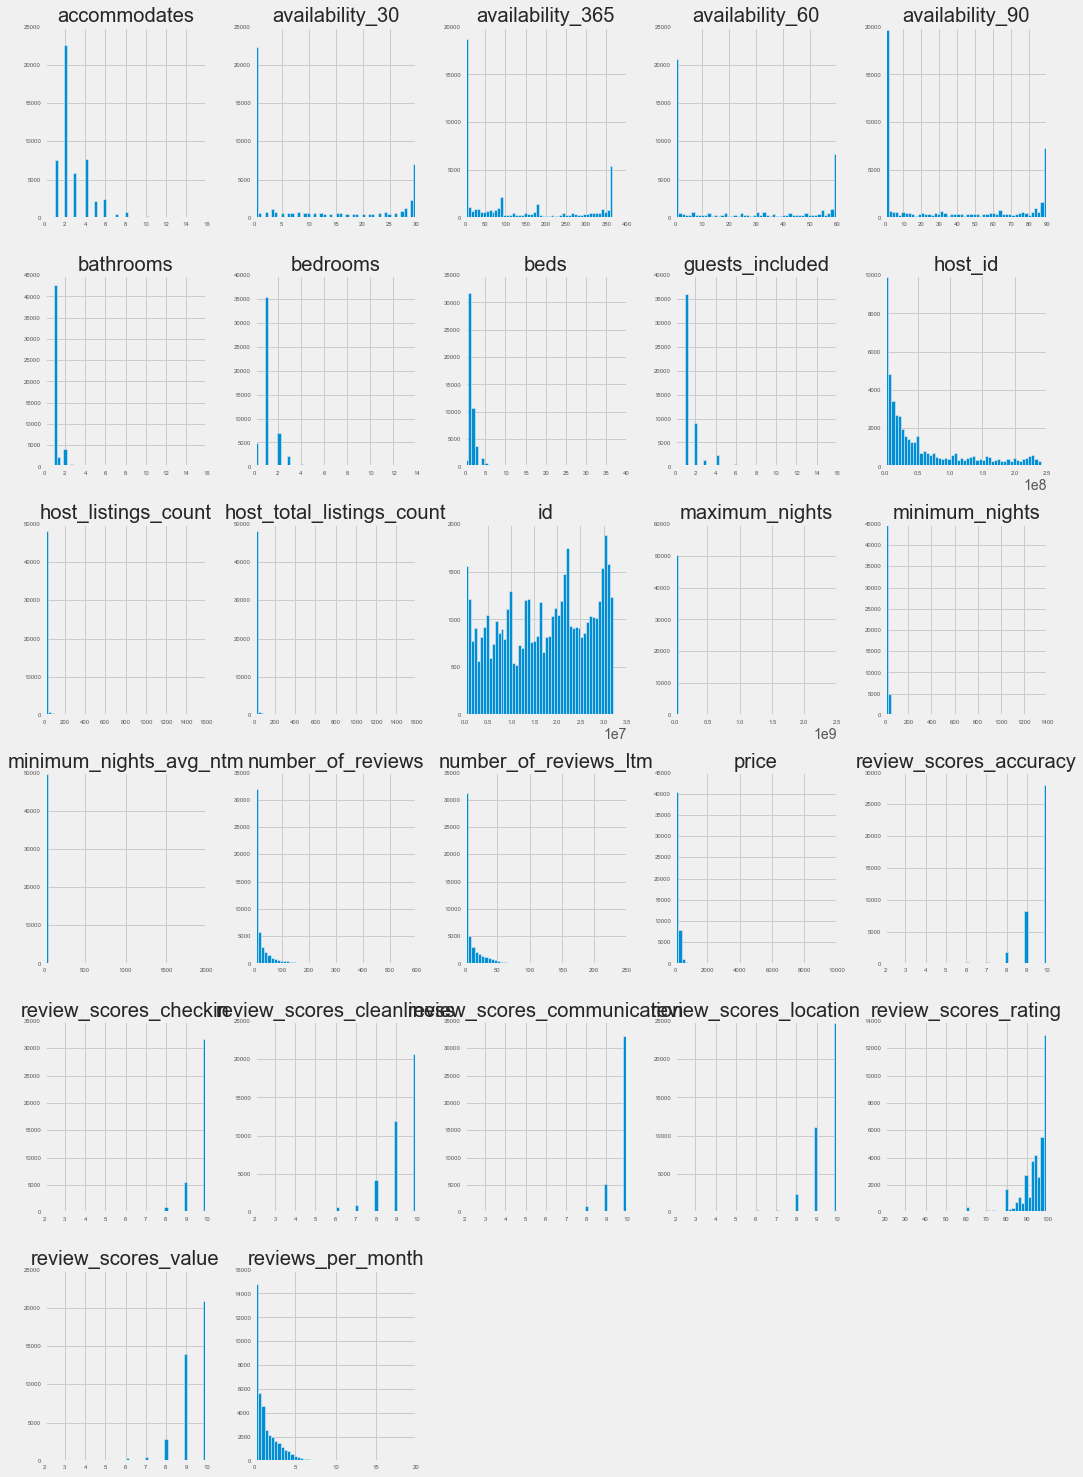

In [1154]:
listings_num = listings.select_dtypes(include = ['float64', 'int64'])
listings_num.hist(figsize=(16, 24), bins=50, xlabelsize=6, ylabelsize=6);

## Correlation Analysis

In [1155]:
listings_corr = listings.corr()['price'] 
sorted(list(zip(listings, listings_corr)), key=lambda tup: tup[1])

[('is_location_exact', -0.0354859825822667),
 ('smart_location', -0.03258905391036314),
 ('amenities', -0.024139316686913277),
 ('bed_type', -0.010880956061165037),
 ('bathrooms', -0.008760928931378352),
 ('id', -0.008672387238149618),
 ('host_has_profile_pic', -0.00039938703962690735),
 ('host_id', 0.0003710296673431187),
 ('bedrooms', 0.0023946219812795108),
 ('room_type', 0.009818359060991681),
 ('host_identity_verified', 0.01029875735995091),
 ('host_verifications', 0.03051504703002474),
 ('property_type', 0.0350774092797216),
 ('host_since', 0.036223223166118174),
 ('host_location', 0.036223223166118174),
 ('zipcode', 0.04555365081308207),
 ('accommodates', 0.046730989743815406),
 ('neighbourhood_cleansed', 0.04930764817548393),
 ('neighbourhood_group_cleansed', 0.05159378697390081),
 ('market', 0.07548743558695921),
 ('beds', 0.08141262875284111),
 ('host_total_listings_count', 0.1795599086041252),
 ('host_response_rate', 0.23417486095025838),
 ('host_is_superhost', 0.26368264072

## Pair Plots

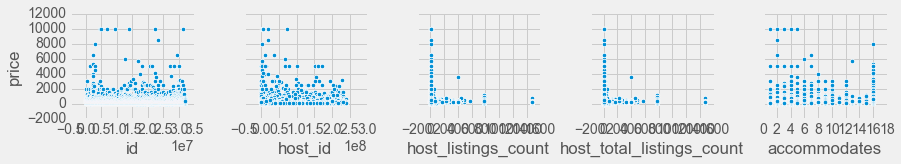

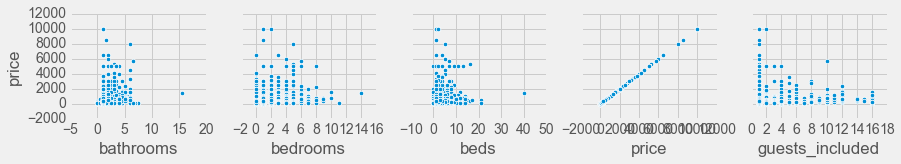

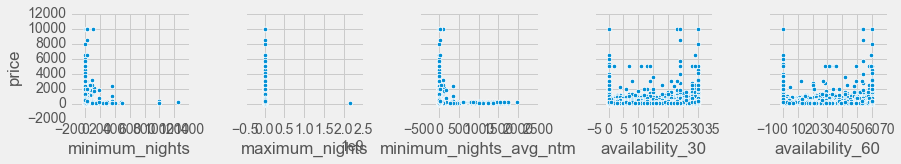

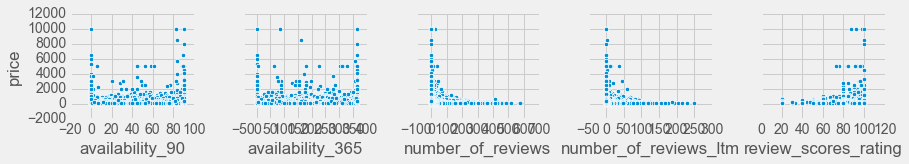

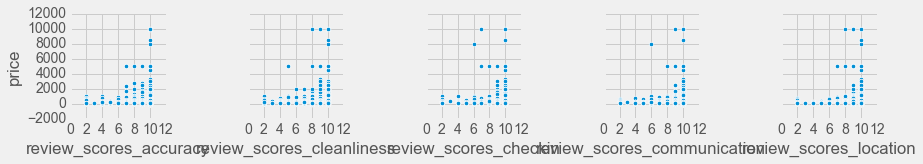

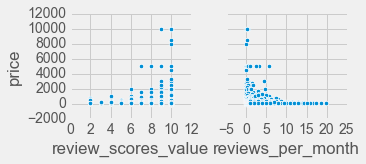

In [1101]:
for i in range(0, len(listings.columns), 5):
    
    sns.pairplot(data=listings,
                x_vars=listings.columns[i:i+5],
                y_vars=['price'],
                )

## Removing Price Outliers

Text(0, 0.5, 'Number of listings')

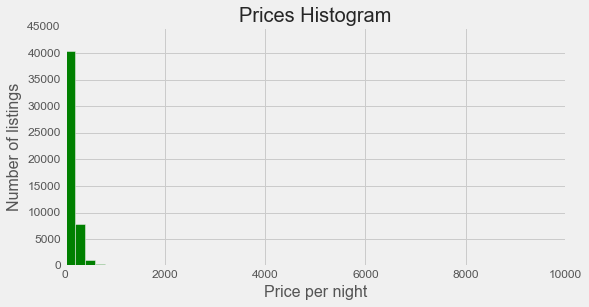

In [1102]:
listings.price.hist(figsize=(8, 4), bins=50, xlabelsize=12, ylabelsize=12, color='green');


plt.title("Prices Histogram", fontsize = 20)
plt.xlabel("Price per night", fontsize = 16)
plt.ylabel("Number of listings", fontsize = 16)



In [1103]:
listings.price.describe()

count    50228.000000
mean       150.484889
std        225.907959
min          0.000000
25%         69.000000
50%        108.000000
75%        175.000000
max      10000.000000
Name: price, dtype: float64

In [1104]:
# Get names of listings for which price has value >= 1000
indexNames =  listings[listings['price'] >= 1000].index
 
# Delete these row indexes from dataFrame
listings = listings.drop(indexNames)

### how many were removed?

In [1105]:
# listings before - 50228
# listings after - 49953
# number of price outliers removed = 275
# % of price outliers removed = 0.5475033845663774

Text(0, 0.5, 'Number of listings')

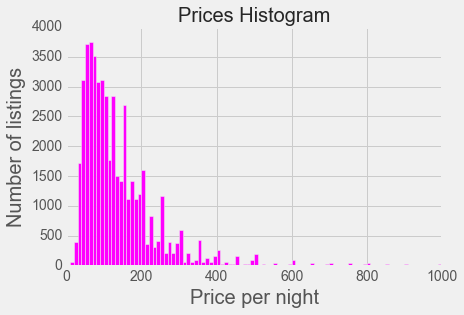

In [1106]:
listings.price.hist(bins = 100, color='#FF00FF')
plt.title("Prices Histogram", fontsize = 20)
plt.xlabel("Price per night", fontsize = 20)
plt.ylabel("Number of listings", fontsize = 20)

## Bedroom Distribution

Text(0, 0.5, 'Number of Airbnbs')

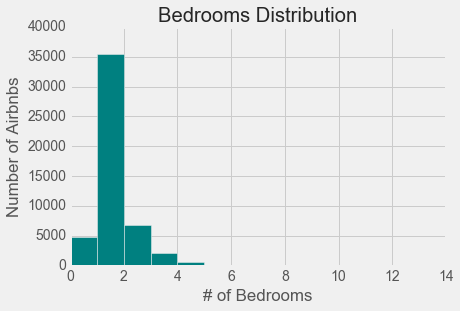

In [1107]:
listings.bedrooms.hist(bins = [0,1,2,3,4,5,6,7,8,9,10,11,12,13],color='#008080')
plt.title("Bedrooms Distribution")
plt.xlabel("# of Bedrooms")
plt.ylabel("Number of Airbnbs")

## Remove listings where price = 0

In [1156]:
indexNames = listings[listings['price'] == 0].index
listings = listings.drop(indexNames)
listings.price.describe()

count    50210.000000
mean       150.538837
std        225.930477
min         10.000000
25%         69.000000
50%        108.000000
75%        175.000000
max      10000.000000
Name: price, dtype: float64

## Remove listings where bedrooms = 0

Text(0, 0.5, 'Number of Airbnbs')

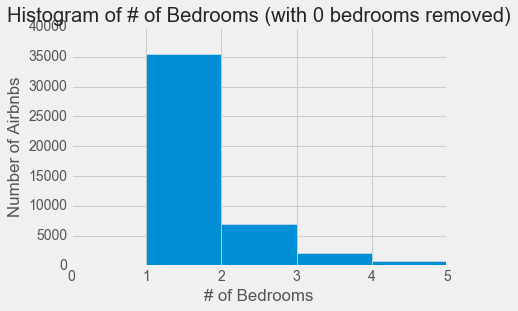

In [1157]:
# Get names of indexes for which column 
indexNames = listings[listings['bedrooms'] == 0].index
 
# Delete these row indexes from dataFrame
listings = listings.drop(indexNames)
listings.bedrooms.hist(bins = [0,1,2,3,4,5])
plt.title("Histogram of # of Bedrooms (with 0 bedrooms removed)")
plt.xlabel("# of Bedrooms")
plt.ylabel("Number of Airbnbs")

# Feature to feature correlations - Numerical Variables

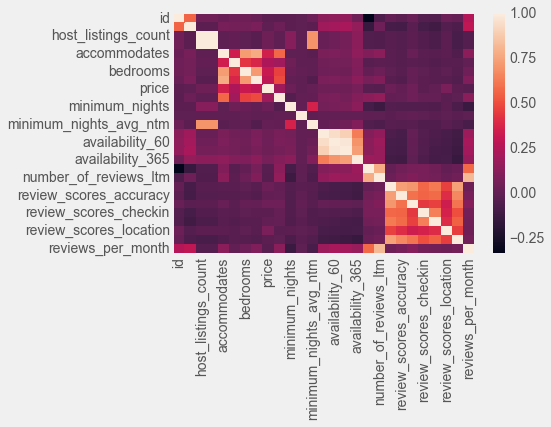

In [1159]:
corr = listings.corr()
sns.heatmap(corr)

In [1158]:
corr["price"].sort_values()

review_scores_value           -0.027423
number_of_reviews             -0.025420
number_of_reviews_ltm         -0.025070
reviews_per_month             -0.020987
id                            -0.010088
maximum_nights                 0.000140
host_id                        0.003277
review_scores_checkin          0.003671
review_scores_communication    0.013060
minimum_nights_avg_ntm         0.015856
review_scores_accuracy         0.016145
minimum_nights                 0.023931
availability_90                0.043739
availability_30                0.050989
availability_60                0.054787
review_scores_rating           0.062538
host_listings_count            0.077276
host_total_listings_count      0.077276
review_scores_cleanliness      0.078472
availability_365               0.107216
review_scores_location         0.147217
bathrooms                      0.283405
guests_included                0.340684
beds                           0.445276
bedrooms                       0.492866


,accommodates,bedrooms,beds,bathrooms,price
accommodates,1.000000,0.728252,0.781561,0.325999,0.557644
bedrooms,0.728252,1.000000,0.716736,0.402434,0.492866
beds,0.781561,0.716736,1.000000,0.345524,0.445276
bathrooms,0.325999,0.402434,0.345524,1.000000,0.283405
price,0.557644,0.492866,0.445276,0.283405,1.000000


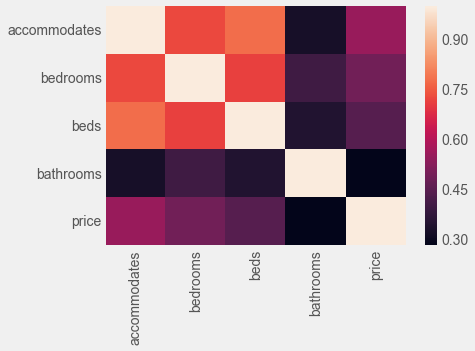

In [1113]:
corr = listings[["accommodates","bedrooms","beds","bathrooms","price"]].corr()
sns.heatmap(corr)
corr

## Checking for collinearity

In [1160]:
corr = listings.corr()
corr_tf = abs(corr) > 0.75

for column in corr_tf:
    for index in corr_tf.index:
        if (corr_tf[column][index] == True) & (index != column): 
            print(f"{column}, {index}")

host_listings_count, host_total_listings_count
host_total_listings_count, host_listings_count
accommodates, beds
beds, accommodates
availability_30, availability_60
availability_30, availability_90
availability_60, availability_30
availability_60, availability_90
availability_90, availability_30
availability_90, availability_60
number_of_reviews, number_of_reviews_ltm
number_of_reviews_ltm, number_of_reviews
number_of_reviews_ltm, reviews_per_month
review_scores_rating, review_scores_value
review_scores_value, review_scores_rating
reviews_per_month, number_of_reviews_ltm


# Linear Regression

In [1115]:
def lr(dependent,independents, dataframe):
    '''
    Takes in target and independent variables from a dataframe as strings. Independent variables are separated by +.
    Performs ols regression and returns summary of model performance.
    '''
    f1 = f'{dependent}~{independents}'
    model1 = smf.ols(formula = f1, data = dataframe).fit()
    return model1.summary()

def lr_resid(dependent,independents, dataframe):
    '''
    Takes in target and independent variables from a dataframe as strings. Independent variables are separated by +.
    Returns residuals of ols regression.
    '''
    f1 = f'{dependent}~{independents}'
    model1 = smf.ols(formula = f1, data = dataframe).fit()
    return model1.resid

def lr_model(dependent,independents, dataframe):
    '''
    Takes in target and independent variables from a dataframe as strings. Independent variables are separated by +.
    Returns model.
    '''
    f1 = f'{dependent}~{independents}'
    model1 = smf.ols(formula = f1, data = dataframe).fit()
    return model1

In [1116]:
lr('price','accommodates', listings)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.311
Model:                            OLS   Adj. R-squared:                  0.311
Method:                 Least Squares   F-statistic:                 2.038e+04
Date:                Sun, 10 Mar 2019   Prob (F-statistic):               0.00
Time:                        22:53:45   Log-Likelihood:            -2.6970e+05
No. Observations:               45150   AIC:                         5.394e+05
Df Residuals:                   45148   BIC:                         5.394e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       40.3080      0.820     49.130      0.000      38.700      41.916
accommodates    33.7761      0.237    142.744      0.000      33.312      34.240
==============================================================================
Omnibus:                    27859.990   Durbin-Watson:                   1.837
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           463158.635
Skew:                           2.691   Prob(JB):                         0.00
Kurtosis:                      17.739   Cond. No.                         6.74
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [1117]:
lr('price','bedrooms', listings)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.243
Model:                            OLS   Adj. R-squared:                  0.243
Method:                 Least Squares   F-statistic:                 1.447e+04
Date:                Sun, 10 Mar 2019   Prob (F-statistic):               0.00
Time:                        22:53:50   Log-Likelihood:            -2.7157e+05
No. Observations:               45107   AIC:                         5.431e+05
Df Residuals:                   45105   BIC:                         5.432e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     28.9649      1.024     28.290      0.000      26.958      30.972
bedrooms      84.1260      0.699    120.301      0.000      82.755      85.497
==============================================================================
Omnibus:                    25654.844   Durbin-Watson:                   1.829
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           355615.234
Skew:                           2.466   Prob(JB):                         0.00
Kurtosis:                      15.841   Cond. No.                         4.46
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [1050]:
lr('price','accommodates+bedrooms', listings)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.289
Model:                            OLS   Adj. R-squared:                  0.289
Method:                 Least Squares   F-statistic:                 1.016e+04
Date:                Sun, 10 Mar 2019   Prob (F-statistic):               0.00
Time:                        22:21:37   Log-Likelihood:            -2.9820e+05
No. Observations:               49910   AIC:                         5.964e+05
Df Residuals:                   49907   BIC:                         5.964e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       40.7056      0.851     47.826      0.000      39.037      42.374
accommodates    29.4602      0.300     98.144      0.000      28.872      30.049
bedrooms        12.2951      0.746     16.488      0.000      10.834      13.757
==============================================================================
Omnibus:                    31504.809   Durbin-Watson:                   1.786
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           541886.409
Skew:                           2.767   Prob(JB):                         0.00
Kurtosis:                      18.164   Cond. No.                         8.31
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [1118]:
lr('price','beds', listings)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.198
Model:                            OLS   Adj. R-squared:                  0.198
Method:                 Least Squares   F-statistic:                 1.116e+04
Date:                Sun, 10 Mar 2019   Prob (F-statistic):               0.00
Time:                        22:53:54   Log-Likelihood:            -2.7289e+05
No. Observations:               45111   AIC:                         5.458e+05
Df Residuals:                   45109   BIC:                         5.458e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     65.4223      0.844     77.533      0.000      63.768      67.076
beds          46.2438      0.438    105.620      0.000      45.386      47.102
==============================================================================
Omnibus:                    26032.847   Durbin-Watson:                   1.840
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           353519.020
Skew:                           2.524   Prob(JB):                         0.00
Kurtosis:                      15.751   Cond. No.                         4.03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [1119]:
lr('price','accommodates+bedrooms+beds', listings)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.328
Model:                            OLS   Adj. R-squared:                  0.328
Method:                 Least Squares   F-statistic:                     7331.
Date:                Sun, 10 Mar 2019   Prob (F-statistic):               0.00
Time:                        22:53:58   Log-Likelihood:            -2.6869e+05
No. Observations:               45073   AIC:                         5.374e+05
Df Residuals:                   45069   BIC:                         5.374e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       22.7663      0.969     23.501      0.000      20.868      24.665
accommodates    27.3684      0.406     67.335      0.000      26.572      28.165
bedrooms        34.3412      1.025     33.512      0.000      32.333      36.350
beds            -5.4134      0.685     -7.905      0.000      -6.756      -4.071
==============================================================================
Omnibus:                    27865.734   Durbin-Watson:                   1.829
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           466624.479
Skew:                           2.695   Prob(JB):                         0.00
Kurtosis:                      17.812   Cond. No.                         11.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## all prices under 1000, no 0 bedrooms

In [1120]:
lr('price','accommodates+bedrooms+review_scores_location', listings)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.396
Model:                            OLS   Adj. R-squared:                  0.396
Method:                 Least Squares   F-statistic:                     7653.
Date:                Sun, 10 Mar 2019   Prob (F-statistic):               0.00
Time:                        22:54:06   Log-Likelihood:            -2.0509e+05
No. Observations:               35086   AIC:                         4.102e+05
Df Residuals:                   35082   BIC:                         4.102e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               -186.3501      5.491    -33.939      0.000    -197.112    -175.588
accommodates              22.9845      0.350     65.662      0.000      22.298      23.671
bedrooms                  38.3990      1.017     37.746      0.000      36.405      40.393
review_scores_location    21.3117      0.567     37.598      0.000      20.201      22.423
==============================================================================
Omnibus:                    19966.451   Durbin-Watson:                   1.945
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           318857.119
Skew:                           2.414   Prob(JB):                         0.00
Kurtosis:                      16.957   Cond. No.                         126.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## creating interaction variables


### interaction terms between accommodates, bedrooms, review_scores_location

In [1121]:
def create_interaction_column(list_of_columns, df):
    '''
    Takes in a list of columns and a dataframe that contains the columns
    Multiplies values together to make an interaction term and adds the interaction term values to a new column in the data frame
    '''
    df["new_column"] = df[list_of_columns[0]]
    for column in list_of_columns[1:]:
        df["new_column"] = df["new_column"] * df[column]
    df.rename(columns = {"new_column":"_".join(list_of_columns)}, inplace = True)  


In [1169]:
create_interaction_column(["accommodates","bedrooms"], listings)

In [1170]:
create_interaction_column(["bedrooms","review_scores_checkin"], listings)

In [1171]:
create_interaction_column(["accommodates","review_scores_checkin"], listings)

In [1172]:
create_interaction_column(["accommodates","bedrooms","review_scores_checkin"], listings)

## R^2 = 0 when review scores checkin is regressed against price

In [1135]:
lr("price","review_scores_checkin",listings)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.4733
Date:                Sun, 10 Mar 2019   Prob (F-statistic):              0.491
Time:                        23:10:27   Log-Likelihood:            -2.1419e+05
No. Observations:               35130   AIC:                         4.284e+05
Df Residuals:                   35128   BIC:                         4.284e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept               129.6886      7.897     16.423      0.000     114.211     145.167
review_scores_checkin     0.5563      0.809      0.688      0.491      -1.029       2.141
==============================================================================
Omnibus:                    21100.541   Durbin-Watson:                   1.949
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           239217.133
Skew:                           2.743   Prob(JB):                         0.00
Kurtosis:                      14.547   Cond. No.                         136.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## R^2 = .33 for current model

In [1137]:
lr('price','accommodates+bedrooms+bathrooms', listings)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.333
Model:                            OLS   Adj. R-squared:                  0.333
Method:                 Least Squares   F-statistic:                     7497.
Date:                Sun, 10 Mar 2019   Prob (F-statistic):               0.00
Time:                        23:11:57   Log-Likelihood:            -2.6834e+05
No. Observations:               45042   AIC:                         5.367e+05
Df Residuals:                   45038   BIC:                         5.367e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        4.6038      1.324      3.478      0.001       2.010       7.198
accommodates    25.2669      0.341     74.191      0.000      24.599      25.934
bedrooms        26.4050      0.991     26.643      0.000      24.462      28.347
bathrooms       22.5801      1.115     20.249      0.000      20.394      24.766
==============================================================================
Omnibus:                    27192.652   Durbin-Watson:                   1.821
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           443757.011
Skew:                           2.616   Prob(JB):                         0.00
Kurtosis:                      17.460   Cond. No.                         14.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Addition of review_scores_checkin boosts model performance

In [1138]:
lr('price','accommodates+bedrooms+bathrooms+review_scores_checkin', listings)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.378
Model:                            OLS   Adj. R-squared:                  0.378
Method:                 Least Squares   F-statistic:                     5317.
Date:                Sun, 10 Mar 2019   Prob (F-statistic):               0.00
Time:                        23:12:25   Log-Likelihood:            -2.0533e+05
No. Observations:               35038   AIC:                         4.107e+05
Df Residuals:                   35033   BIC:                         4.107e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept               -21.4318      6.413     -3.342      0.001     -34.001      -8.863
accommodates             22.5423      0.356     63.332      0.000      21.845      23.240
bedrooms                 33.5341      1.064     31.517      0.000      31.449      35.620
bathrooms                22.3034      1.180     18.893      0.000      19.990      24.617
review_scores_checkin     2.0433      0.639      3.197      0.001       0.791       3.296
==============================================================================
Omnibus:                    18630.846   Durbin-Watson:                   1.938
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           259277.739
Skew:                           2.247   Prob(JB):                         0.00
Kurtosis:                      15.546   Cond. No.                         148.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Categorical Variables

In [1139]:
def get_dummy_variables(column,df):
    '''
    Takes in a category column from a dataframe, coverts into a category datatype, and applies the get_dummies method
    to the column. Column name is prepended to each dummy column name. Returns a dataframe of coverted dummy variables.
    '''
    categories = df[column].astype('category')
    return pd.get_dummies(categories, prefix=column)

def get_dummy_variable_names(column,df):
    '''
    Returns list of dummy variable column names.
    '''
    return get_dummy_variables(column,df).columns



In [1161]:
listings.columns

Index(['id', 'host_id', 'host_since', 'host_location', 'host_response_time',
       'host_response_rate', 'host_is_superhost', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'zipcode',
       'market', 'smart_location', 'is_location_exact', 'property_type',
       'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
       'bed_type', 'amenities', 'price', 'security_deposit', 'cleaning_fee',
       'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights',
       'minimum_nights_avg_ntm', 'calendar_updated', 'has_availability',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'calendar_last_scraped', 'number_of_reviews',
       'number_of_reviews_ltm', 'first_review', 'last_review',
       'review_scores_rating', 'review_scores_accuracy',
       're

## Creating dummy variables for zipcode

In [1162]:
listings = pd.concat([listings,(get_dummy_variables('zipcode', listings))],axis=1)

In [1163]:
listings.columns.values

array(['id', 'host_id', 'host_since', 'host_location',
       'host_response_time', 'host_response_rate', 'host_is_superhost',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed',
       'zipcode', 'market', 'smart_location', 'is_location_exact',
       'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bedrooms', 'beds', 'bed_type', 'amenities', 'price',
       'security_deposit', 'cleaning_fee', 'guests_included',
       'extra_people', 'minimum_nights', 'maximum_nights',
       'minimum_nights_avg_ntm', 'calendar_updated', 'has_availability',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'calendar_last_scraped', 'number_of_reviews',
       'number_of_reviews_ltm', 'first_review', 'last_review',
       'review_scores_rating', 'review_scores_accurac

In [1164]:
zipcode_list = list(get_dummy_variable_names('zipcode',listings))

## Dropping one dummy variable

In [1166]:
zipcode_list=zipcode_list[:-1]

In [1167]:
zipcode_str = '+'.join(zipcode_list)

In [1173]:
lr('price',f"bedrooms+accommodates+{zipcode_str}+review_scores_checkin+bedrooms_review_scores_checkin+bathrooms",listings)

/Users/carolinevanacore/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:1100: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/Users/carolinevanacore/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/carolinevanacore/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/carolinevanacore/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.219
Model:                            OLS   Adj. R-squared:                  0.215
Method:                 Least Squares   F-statistic:                     51.42
Date:                Sun, 10 Mar 2019   Prob (F-statistic):               0.00
Time:                        23:37:11   Log-Likelihood:            -2.3248e+05
No. Observations:               35159   AIC:                         4.654e+05
Df Residuals:                   34967   BIC:                         4.670e+05
Df Model:                         191                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                       -195.7568     29.974     -6.531      0.000    -254.506    -137.007
bedrooms                         157.1137     19.320      8.132      0.000     119.245     194.982
accommodates                      24.3270      0.760     32.015      0.000      22.838      25.816
zipcode_07093                      5.4440    180.798      0.030      0.976    -348.925     359.814
zipcode_10001                     76.1035     13.391      5.683      0.000      49.858     102.349
zipcode_10002                     35.7930     10.282      3.481      0.001      15.639      55.947
zipcode_10003                     66.9541     10.774      6.215      0.000      45.837      88.071
zipcode_10004                     54.5346     32.100      1.699      0.089      -8.382     117.452
zipcode_10005                     27.0497     19.108      1.416      0.157     -10.403      64.502
zipcode_10006                     70.5990     34.033      2.074      0.038       3.894     137.304
zipcode_10007                    225.4173     42.306      5.328      0.000     142.497     308.338
zipcode_10009                     23.4059     10.423      2.246      0.025       2.977      43.835
zipcode_10010                     70.9538     14.596      4.861      0.000      42.345      99.563
zipcode_10011                     86.1086     11.419      7.541      0.000      63.727     108.490
zipcode_10012                     90.6169     11.402      7.947      0.000      68.268     112.966
zipcode_10013                    101.2704     12.863      7.873      0.000      76.059     126.482
zipcode_10014                    104.4748     11.557      9.040      0.000      81.824     127.126
zipcode_10016                     38.9663     11.156      3.493      0.000      17.100      60.833
zipcode_10017                    119.8756     16.786      7.141      0.000      86.974     152.777
zipcode_10018                     59.7298     13.715      4.355      0.000      32.848      86.612
zipcode_10019                     49.8234     10.556      4.720      0.000      29.134      70.513
zipcode_10021                     31.9785     15.528      2.059      0.039       1.544      62.413
zipcode_10022                     67.2715     13.657      4.926      0.000      40.504      94.039
zipcode_10023                     51.4497     13.271      3.877      0.000      25.439      77.461
zipcode_10024                     36.2595     13.195      2.748      0.006      10.397      62.122
zipcode_10025                     21.8614     10.861      2.013      0.044       0.574      43.149
zipcode_10026                    -19.8213     12.240     -1.619      0.105     -43.813       4.170
zipcode_10027                    -21.7449     11.057     -1.967      0.049     -43.418      -0.072
zipcode_10028 

## Creating room type dummy variables

In [772]:
room_type_dummies = get_dummy_variables("room_type", listings)
room_type_list = get_dummy_variable_names("room_type",listings)

for column_name in room_type_dummies:
    room_type_dummies.rename(columns = {column_name: column_name.replace(' ', '_').replace('/','')}, inplace = True)

room_type_list = room_type_dummies.columns
room_type_list

Index(['room_type_Entire_homeapt', 'room_type_Private_room',
       'room_type_Shared_room'],
      dtype='object')

In [932]:
room_type_dummies

,room_type_Entire_homeapt,room_type_Private_room,room_type_Shared_room
1,0,1,0
3,0,1,0
4,0,1,0
5,1,0,0
6,1,0,0
7,1,0,0
8,0,1,0
9,0,1,0
10,0,1,0
11,1,0,0


In [1174]:
listings = pd.concat([listings, room_type_dummies], axis = 1)

In [1175]:
room_type_string = '+'.join((list(room_type_list[:-1])))
room_type_string

'room_type_Entire_homeapt+room_type_Private_room'

In [1176]:
model = lr('price', f"accommodates+{zipcode_str}+bedrooms+review_scores_location+{room_type_string}+bathrooms+guests_included", listings)

In [1177]:
lr('price', f"accommodates+{zipcode_str}+bedrooms+review_scores_location+{room_type_string}+bathrooms+guests_included", listings)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.590
Model:                            OLS   Adj. R-squared:                  0.587
Method:                 Least Squares   F-statistic:                     259.3
Date:                Sun, 10 Mar 2019   Prob (F-statistic):               0.00
Time:                        23:38:38   Log-Likelihood:            -1.9802e+05
No. Observations:               35034   AIC:                         3.964e+05
Df Residuals:                   34840   BIC:                         3.981e+05
Df Model:                         193                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                  -57.3340      6.411     -8.943      0.000     -69.900     -44.768
accommodates                12.4335      0.344     36.135      0.000      11.759      13.108
zipcode_07093               23.8260     69.222      0.344      0.731    -111.851     159.503
zipcode_10001               78.1295      5.139     15.203      0.000      68.057      88.202
zipcode_10002               20.7859      3.944      5.270      0.000      13.055      28.517
zipcode_10003               42.8689      4.146     10.339      0.000      34.742      50.996
zipcode_10004               51.9996     12.293      4.230      0.000      27.905      76.094
zipcode_10005               27.4934      7.321      3.755      0.000      13.143      41.844
zipcode_10006               63.8286     13.032      4.898      0.000      38.285      89.372
zipcode_10007              115.0131     17.084      6.732      0.000      81.529     148.498
zipcode_10009               20.6885      3.998      5.174      0.000      12.851      28.526
zipcode_10010               66.8888      5.596     11.953      0.000      55.921      77.857
zipcode_10011               66.5795      4.398     15.139      0.000      57.960      75.199
zipcode_10012               63.3618      4.388     14.439      0.000      54.760      71.963
zipcode_10013               61.8840      4.961     12.473      0.000      52.160      71.608
zipcode_10014               71.8157      4.465     16.085      0.000      63.065      80.567
zipcode_10016               40.9254      4.285      9.551      0.000      32.527      49.324
zipcode_10017              105.4247      6.466     16.304      0.000      92.751     118.098
zipcode_10018               49.0188      5.274      9.295      0.000      38.682      59.356
zipcode_10019               40.9694      4.060     10.091      0.000      33.011      48.927
zipcode_10021               14.0084      5.974      2.345      0.019       2.298      25.718
zipcode_10022               47.6243      5.277      9.024      0.000      37.280      57.968
zipcode_10023               42.0909      5.097      8.258      0.000      32.100      52.081
zipcode_10024               24.7805      5.073      4.885      0.000      14.838      34.723
zipcode_10025                8.1727      4.176      1.957      0.050      -0.012      16.358
zipcode_10026              -12.2446      4.695     -2.608      0.009     -21.446      -3.043
zipcode_10027              -16.7996      4.241     -3.961      0.000     -25.112      -8.488
zipcode_10028               16.0142      5.276      3.035      0.002       5.673      26.356
zipcode_10029              -12.6920      4.368     -2.906      0.004     -21.253      -4.131
zipcode_10030              -25.4585      5.213     -4.884      0.000     -35.676     -15.241
zipcode_10031 

## Creating dummy variables for property type

In [776]:
property_type_dummies = get_dummy_variables("property_type", listings)
list(property_type_dummies.columns)


['property_type_Aparthotel',
 'property_type_Apartment',
 'property_type_Bed and breakfast',
 'property_type_Boat',
 'property_type_Boutique hotel',
 'property_type_Bungalow',
 'property_type_Bus',
 'property_type_Cabin',
 'property_type_Camper/RV',
 'property_type_Casa particular (Cuba)',
 'property_type_Castle',
 'property_type_Cave',
 'property_type_Condominium',
 'property_type_Cottage',
 'property_type_Earth house',
 'property_type_Farm stay',
 'property_type_Guest suite',
 'property_type_Guesthouse',
 'property_type_Hostel',
 'property_type_Hotel',
 'property_type_House',
 'property_type_Houseboat',
 'property_type_Loft',
 'property_type_Minsu (Taiwan)',
 'property_type_Nature lodge',
 'property_type_Other',
 'property_type_Resort',
 'property_type_Serviced apartment',
 'property_type_Tent',
 'property_type_Tiny house',
 'property_type_Townhouse',
 'property_type_Treehouse',
 'property_type_Villa']

In [1180]:
listings.columns.values

array(['id', 'host_id', 'host_since', 'host_location',
       'host_response_time', 'host_response_rate', 'host_is_superhost',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed',
       'zipcode', 'market', 'smart_location', 'is_location_exact',
       'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bedrooms', 'beds', 'bed_type', 'amenities', 'price',
       'security_deposit', 'cleaning_fee', 'guests_included',
       'extra_people', 'minimum_nights', 'maximum_nights',
       'minimum_nights_avg_ntm', 'calendar_updated', 'has_availability',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'calendar_last_scraped', 'number_of_reviews',
       'number_of_reviews_ltm', 'first_review', 'last_review',
       'review_scores_rating', 'review_scores_accurac

In [1178]:
# Is there a castle in NYC?!?!?!?!?!?!
listings.loc[big_d['property_type'] == 'Castle']

KeyError: 'property_type'

In [1181]:
model_resid = lr_resid('price', f"accommodates+{zipcode_str}+bedrooms+review_scores_location+{room_type_string}+bathrooms+guests_included", listings)

In [1182]:
# plt.scatter(x = big_d.price,y = model_resid)
listings["model_resid"]=model_resid

# big_d['model_predicted'] = lr_model.

big_model_d = lr_model("price",f"accommodates+{zipcode_str}+bedrooms+review_scores_location+{room_type_string}+bathrooms+guests_included", listings)
listings['fitted_values'] = big_model_d.fittedvalues

In [780]:
listings["fitted_values"]

1         65.148251
3         64.481782
4               NaN
5        135.505390
6               NaN
7        184.214240
8               NaN
9        134.482063
10        89.251868
11              NaN
12       176.508280
13       146.406168
14       137.824421
15       182.498274
16        72.077441
17        85.890015
18       200.977557
19              NaN
20        68.387121
21        36.919399
22       149.993982
23       177.581069
24       136.582970
25              NaN
27       210.122431
28       257.695340
29       321.975754
30       150.710005
31        40.281252
32              NaN
            ...    
50195           NaN
50197           NaN
50198           NaN
50199           NaN
50200           NaN
50201           NaN
50202           NaN
50203           NaN
50204           NaN
50205           NaN
50206           NaN
50207           NaN
50208           NaN
50209           NaN
50210           NaN
50211           NaN
50212           NaN
50213           NaN
50214           NaN


## Best model so far

In [962]:
lr('price',f"bedrooms+accommodates+review_scores_location+bathrooms+guests_included+{zipcode_str}+{room_type_string}",listings)

/Users/carolinevanacore/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:1100: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/Users/carolinevanacore/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/carolinevanacore/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/carolinevanacore/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.590
Model:                            OLS   Adj. R-squared:                  0.587
Method:                 Least Squares   F-statistic:                     259.3
Date:                Fri, 08 Mar 2019   Prob (F-statistic):               0.00
Time:                        15:32:13   Log-Likelihood:            -1.9802e+05
No. Observations:               35034   AIC:                         3.964e+05
Df Residuals:                   34840   BIC:                         3.981e+05
Df Model:                         193                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                  -57.3340      6.411     -8.943      0.000     -69.900     -44.768
bedrooms                    32.1033      0.881     36.456      0.000      30.377      33.829
accommodates                12.4335      0.344     36.135      0.000      11.759      13.108
review_scores_location       3.3619      0.509      6.600      0.000       2.363       4.360
bathrooms                   36.3034      0.987     36.776      0.000      34.369      38.238
guests_included              5.0554      0.388     13.043      0.000       4.296       5.815
zipcode_07093               23.8260     69.222      0.344      0.731    -111.851     159.503
zipcode_10001               78.1295      5.139     15.203      0.000      68.057      88.202
zipcode_10002               20.7859      3.944      5.270      0.000      13.055      28.517
zipcode_10003               42.8689      4.146     10.339      0.000      34.742      50.996
zipcode_10004               51.9996     12.293      4.230      0.000      27.905      76.094
zipcode_10005               27.4934      7.321      3.755      0.000      13.143      41.844
zipcode_10006               63.8286     13.032      4.898      0.000      38.285      89.372
zipcode_10007              115.0131     17.084      6.732      0.000      81.529     148.498
zipcode_10009               20.6885      3.998      5.174      0.000      12.851      28.526
zipcode_10010               66.8888      5.596     11.953      0.000      55.921      77.857
zipcode_10011               66.5795      4.398     15.139      0.000      57.960      75.199
zipcode_10012               63.3618      4.388     14.439      0.000      54.760      71.963
zipcode_10013               61.8840      4.961     12.473      0.000      52.160      71.608
zipcode_10014               71.8157      4.465     16.085      0.000      63.065      80.567
zipcode_10016               40.9254      4.285      9.551      0.000      32.527      49.324
zipcode_10017              105.4247      6.466     16.304      0.000      92.751     118.098
zipcode_10018               49.0188      5.274      9.295      0.000      38.682      59.356
zipcode_10019               40.9694      4.060     10.091      0.000      33.011      48.927
zipcode_10021               14.0084      5.974      2.345      0.019       2.298      25.718
zipcode_10022               47.6243      5.277      9.024      0.000      37.280      57.968
zipcode_10023               42.0909      5.097      8.258      0.000      32.100      52.081
zipcode_10024               24.7805      5.073      4.885      0.000      14.838      34.723
zipcode_10025                8.1727      4.176      1.957      0.050      -0.012      16.358
zipcode_10026              -12.2446      4.695     -2.608      0.009     -21.446      -3.043
zipcode_10027 

## Residuals plot is heteroscedastic

Text(0, 0.5, 'Residuals')

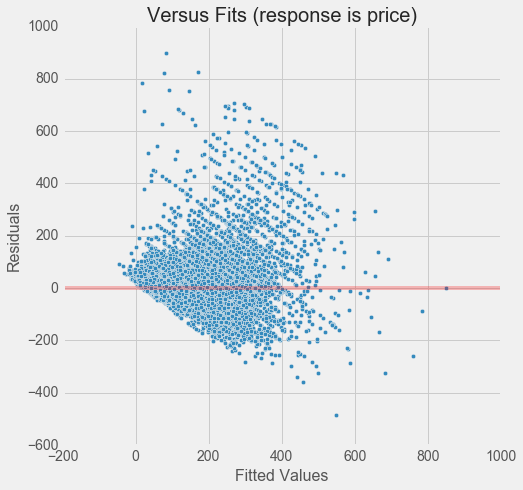

In [1183]:

plot = listings.plot(kind='scatter',x="fitted_values",y="model_resid", figsize=(7,7))
plot.axes.axhline(y = 0, alpha = .25, color = 'r')


plt.title("Versus Fits (response is price)", fontsize = 20)
plt.xlabel("Fitted Values", fontsize = 16)
plt.ylabel("Residuals", fontsize = 16)



Text(0.5, 1.0, 'Histogram of Residuals')

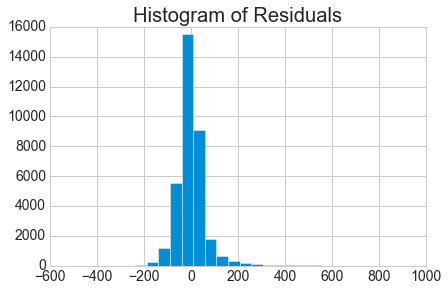

In [1196]:
listings.model_resid.hist(bins = 28)
plt.title("Histogram of Residuals")

## Log transform price

In [1185]:
listings["log_price"] = np.log(listings.price)

In [1186]:
log_resid = lr_resid('log_price',f"bedrooms+accommodates+review_scores_location+bathrooms+guests_included+{zipcode_str}+{room_type_string}",listings)

In [1187]:
listings.log_price.describe()

count    45396.000000
mean         4.700614
std          0.708970
min          2.302585
25%          4.174387
50%          4.605170
75%          5.164786
max          9.210340
Name: log_price, dtype: float64

In [638]:
# Get names of indexes for which column Age has value 30
# indexNames = big_d[big_d['price'] == 1000].index
 
# # Delete these row indexes from dataFrame
# big_d.drop(indexNames).price.describe()

1        5.003946
3        4.248495
4        5.010635
5        4.488636
6        4.382027
7        5.220356
8        4.094345
9        4.369448
10       4.369448
11       4.836282
12       5.010635
13       4.905275
14       4.442651
15       5.164786
16       4.488636
17       4.442651
18       5.164786
19       4.941642
20       4.317488
21       4.174387
22       5.370638
23       4.941642
24       4.595120
25       5.700444
27       4.867534
28       4.605170
29       5.351858
30       4.787492
31       4.094345
32       4.382027
           ...   
50195    4.700480
50197    4.595120
50198    4.499810
50199    4.025352
50200    3.912023
50201    4.110874
50202    3.912023
50203    3.555348
50204    3.555348
50205    4.204693
50206    5.010635
50207    4.094345
50208    4.787492
50209    3.737670
50210    5.010635
50211    5.273000
50212    4.189655
50213    5.241747
50214    4.787492
50215    5.135798
50217    4.356709
50218    5.703782
50219    4.442651
50220    3.555348
50222    3

In [798]:
log_resid = lr_resid('log_price',f"bedrooms+accommodates+{zipcode_str}+review_scores_checkin+bedrooms_review_scores_checkin+bathrooms",listings)

In [1190]:
# plt.scatter(x = big_d.price,y = model_resid)
listings["model_resid_log"]=log_resid

# big_d['model_predicted'] = lr_model.

log_model = lr_model("price",f"bedrooms+accommodates+review_scores_location+bathrooms+guests_included+{zipcode_str}+{room_type_string}",listings)
listings['fitted_values_log'] = log_model.fittedvalues



## Residuals of log price model are more homoscedastic

Text(0, 0.5, 'Residuals')

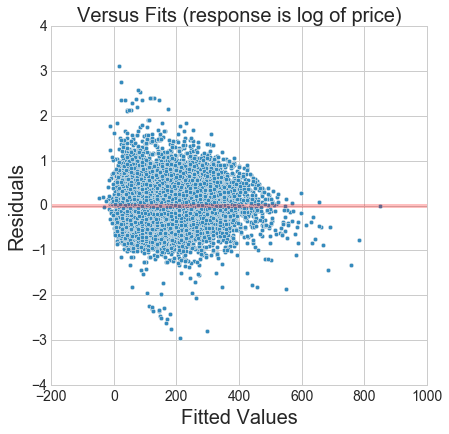

In [1197]:
plot = listings.plot(kind='scatter',x="fitted_values_log",y="model_resid_log", figsize=(6,6))
plot.axes.axhline(y = 0, alpha = .25, color = 'r')
plt.title("Versus Fits (response is log of price)", fontsize = 20)
plt.xlabel("Fitted Values", fontsize = 20)
plt.ylabel("Residuals", fontsize = 20)


In [1192]:
lr('log_price', f"accommodates+{zipcode_str}+bedrooms+review_scores_location+{room_type_string}+bathrooms+guests_included+reviews_per_month", listings)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.702
Model:                            OLS   Adj. R-squared:                  0.700
Method:                 Least Squares   F-statistic:                     422.8
Date:                Sun, 10 Mar 2019   Prob (F-statistic):               0.00
Time:                        23:58:54   Log-Likelihood:                -13891.
No. Observations:               35033   AIC:                         2.817e+04
Df Residuals:                   34838   BIC:                         2.982e+04
Df Model:                         194                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    3.3220      0.033     99.302      0.000       3.256       3.388
accommodates                 0.0785      0.002     43.254      0.000       0.075       0.082
zipcode_07093                0.3145      0.361      0.871      0.384      -0.393       1.022
zipcode_10001                0.4019      0.027     14.989      0.000       0.349       0.454
zipcode_10002                0.2038      0.021      9.901      0.000       0.163       0.244
zipcode_10003                0.2968      0.022     13.710      0.000       0.254       0.339
zipcode_10004                0.2984      0.064      4.651      0.000       0.173       0.424
zipcode_10005                0.3084      0.038      8.074      0.000       0.234       0.383
zipcode_10006                0.4235      0.068      6.227      0.000       0.290       0.557
zipcode_10007                0.4006      0.089      4.494      0.000       0.226       0.575
zipcode_10009                0.2110      0.021     10.113      0.000       0.170       0.252
zipcode_10010                0.3619      0.029     12.392      0.000       0.305       0.419
zipcode_10011                0.4131      0.023     17.997      0.000       0.368       0.458
zipcode_10012                0.3789      0.023     16.546      0.000       0.334       0.424
zipcode_10013                0.3563      0.026     13.763      0.000       0.306       0.407
zipcode_10014                0.4344      0.023     18.638      0.000       0.389       0.480
zipcode_10016                0.2853      0.022     12.759      0.000       0.241       0.329
zipcode_10017                0.5193      0.034     15.387      0.000       0.453       0.585
zipcode_10018                0.3307      0.028     12.015      0.000       0.277       0.385
zipcode_10019                0.3404      0.021     16.067      0.000       0.299       0.382
zipcode_10021                0.1824      0.031      5.851      0.000       0.121       0.243
zipcode_10022                0.3327      0.028     12.083      0.000       0.279       0.387
zipcode_10023                0.3328      0.027     12.509      0.000       0.281       0.385
zipcode_10024                0.2265      0.026      8.556      0.000       0.175       0.278
zipcode_10025                0.1294      0.022      5.935      0.000       0.087       0.172
zipcode_10026                0.0386      0.024      1.577      0.115      -0.009       0.087
zipcode_10027               -0.0160      0.022     -0.723      0.469      -0.059       0.027
zipcode_10028                0.1907      0.028      6.924      0.000       0.137       0.245
zipcode_10029                0.0131      0.023      0.573      0.567      -0.032       0.058
zipcode_10030               -0.1397      0.027     -5.137      0.000      -0.193      -0.086
zipcode_10031 

Text(0.5, 1.0, 'Histogram of Residuals (for Log Model)')

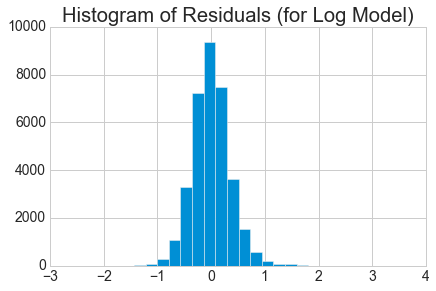

In [1195]:
listings.model_resid_log.hist(bins = 28)
plt.title("Histogram of Residuals (for Log Model)")